# Other Computer Vision Problems

In [33]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

## Multi-Label Classification

Multi-label classification refers to classifying images with possibly zero, one, or multiple labels.

### The Data

Get data from PASCAL dataset:

In [31]:
path = untar_data(URLs.PASCAL_2007)

Inspect the CSV file to see what labels to use for each image.

In [2]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

Get all rows and the first column of the `DataFrame`.

In [3]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

Get the first row and all associated columns of the data frame.

In [4]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

Get all data from the `fname` column.

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

Build a sample `DataFrame` with columns `a` and `b`.

In [6]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


Create a new column `c`.

In [7]:
tmp_df['c'] = tmp_df['a'] + tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

We can convert a `DataFrame` to a `DataLoaders` object by following the steps:

1. Create a `DataBlock`
2. Create a `DataSet` by passing the `DataFrame` through the `DataBlock.datasets`

OR

1. Create a `DataBlock`
2. Create a `DataLoader` by passing the `DataFrame` through the `DataBlock.dataloaders`

In [8]:
dblock = DataBlock()

In [9]:
dsets = dblock.datasets(df)

In [10]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [11]:
x,y = dsets.train[0]
x,y

(fname       001818.jpg
 labels            bird
 is_valid          True
 Name: 899, dtype: object,
 fname       001818.jpg
 labels            bird
 is_valid          True
 Name: 899, dtype: object)

In [12]:
x['fname']

'001818.jpg'

Constructing a `DataBlock` to get inputs and labels with lambda functions.

In [13]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('007482.jpg', 'person sofa')

Constructing a `DataBlock` using functions, which is a more verbose.

In [14]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('007413.jpg', 'aeroplane person')

In order to make the inputs useful, they need to be paths to the image so that they can be opened. We add the path to the front of `r[fname]` and split the labels across the spaces.

In [15]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/scratch/cs344/data/pascal_2007/train/009434.jpg'), ['car', 'person'])

We use a `MultiCategoryBlock` instead of a `CategoryBlock`, since the `CategoryBlock` only returns one integer. `MultiCategoryBlock` returns a tensor of integers. These integers are either 0 or 1, representing whether the provided image has a certain label or not.

In [16]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    get_x = get_x, 
                    get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0], dsets.train.vocab

((PILImage mode=RGB size=500x333,
  TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.])),
 ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

`dsets.train[0]` refers to the list we see above. Index 1 of that list contains the `TensorMultiCategory` object. This code iterates through the entire tensor list and gets the index of the list items that are equal to 1. We then check the indices in the vocabulary.

In [17]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['person']

So far, DataBlock has been randomly splitting our images into training sets and validation sets. However, if we want to control which images are put into training sets, we can define a function `splitter`. 

The `~df['is_valid']` takes each value under the `is_valid` column and negates/flips it. The images that have `is_valid` set to "False" have their labels flipped to "True", and their indices are subsequently put into a list.

To get the valid set, the images with `is_valid` set to "True" have their indices added to another list.

In [18]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)
dls = dblock.dataloaders(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

Finally, we add `item_tfms` to ensure all images are the same size.

In [19]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

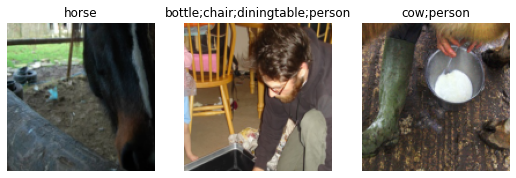

In [20]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [21]:
learn = cnn_learner(dls, resnet18)

We can separate the training set images and the labels from one batfch by calling `dls.train.one_batch`. We then map the resulting tensors to the CPU. We can then get the activations for the entire batch. The shape shows that there are 64 images in the batch, with each image having 20 possible categories.

In [22]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

Below, we can see the confidences for each category for the first image. However, these confidences are not all between 0 and 1.

In [23]:
activs[0]

tensor([-2.2221, -0.6322, -1.2703,  2.1477, -2.3489, -3.0371, -2.8633, -1.5179,
        -1.8004,  1.1284, -2.4139, -1.1236,  4.4943, -1.0260, -1.2832, -2.3841,
        -1.7120,  2.4966, -1.7158, -0.1650], grad_fn=<SelectBackward>)

Define the `binary_cross_entropy` function, which takes the sigmoid of the inputs and compares each activation to each corresponding target. E.g. if the targets are \[0, 0, 1, 0\], then the activations in indices 0, 1, and 3 are going to remain the same before being put into log and mean. The activation in index 2 is going to be subtracted from 1 before being put into the log and mean.

In [24]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

We can use the function `nn.BCEWithLogitsLoss()` to calculate the sigmoid and then do binary cross-entropy.

In [25]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0399, grad_fn=<AliasBackward>)

The next two code blocks show an example of a Python partial. The block below creates a function `say_hello` with a default `say` parameter as "Hello"

In [26]:
def say_hello(name, say="Hello"): return f"{say} {name}."
say_hello("Jimothy"), say_hello("Jimothy", "Ahoy!")

('Hello Jimothy.', 'Ahoy! Jimothy.')

Using the function `partial`, we can pass different parameters into `say_hello` to override `say`'s default value.

In [27]:
f = partial(say_hello, say="Bonjour")
f("Jimothy"), f("Bobert")

('Bonjour Jimothy.', 'Bonjour Bobert.')

Use the `partial` function to specify a threshold. The threshold will cause all values above 0.2 to be considered a 1, and all values below 0.2 to be considered a 0.

In [28]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.987045,0.733207,0.197191,00:10
1,0.865429,0.573652,0.226036,00:08
2,0.637115,0.218218,0.802610,00:08
3,0.387288,0.142368,0.932410,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.154073,0.128429,0.935100,00:10
1,0.137198,0.120794,0.937370,00:10
2,0.119749,0.118022,0.941096,00:10


If we try a very low threshold and call `validate`, we get a validation loss and metric.

In [29]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11802178621292114,0.9130280613899231]

If we try a very high threshold, we only choose the labels in which are model is extremely confident on.

In [30]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.11802178621292114,0.9373106956481934]

Get the `preds` (model-based predictions) and `targs` (the actual values of each label in each image). We call `accuracy_multi` to get the metric directly. We also specify `sigmoid=False`, since `get_preds` already applies the sigmoid function for us.

In [31]:
preds,targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9493)

What the code does below:

1. Create a one-dimensional tensor with 29 values, which are evenly spaced from 0.05 to 0.95. Each value in this tensor is a threshold we will use.

2. Compute the `accuracy_multi` metric for each threshold in that tensor.

3. Plot the accuracy metric over each threshold.

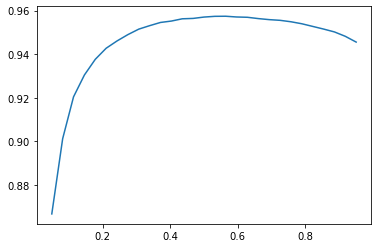

In [32]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

## Regression

From the textbook: "A model is defined by its independent and dependent variables."

Independent variables can be images, dependent variables can be auto-generated captions, labels, etc. In the case of *image regression*, the independent variables are images and the dependent variables are float values. A *key point* is a specific location represented in an image.

### Assemble the Data

Get data (images of people):

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

Inspect the contents of the data:

In [4]:
Path.BASE_PATH = path
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

Look inside one of the directories:

In [5]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Get all images with `get_image_files`. Then, create a function that takes in an image filename and outputs the corresponding .txt filename.

In [6]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('10/frame_00112_pose.txt')

Inspect one of the images:

In [7]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

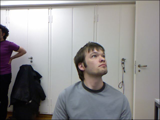

In [8]:
im.to_thumb(160)

Below is the function used to extract the head center point:

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

Test out the function; it should output a pair of float values which represent the coordinates of the center of the head in the image.

In [10]:
get_ctr(img_files[0])

tensor([402.0617, 240.1534])

Create a `DataBlock` for the Biwi images. We use a `PointBlock` such that fastai knows the labels represent coordinates. Our `splitter` will take the images from directory 13 (images for one unique person) and use only those for validation.

In [11]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

Show a batch from the Biwi `DataBlock`.

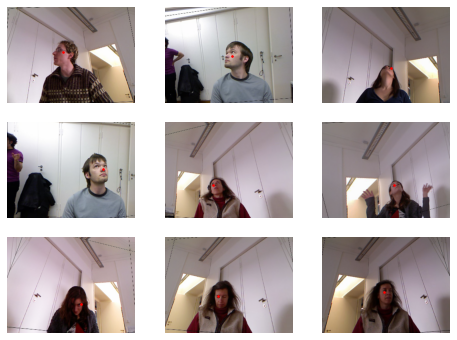

In [12]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

`xb` contains the image data. 64 images, 3 RGB values for each pixel, height of 240 pixels, width of 320 pixels.

`yb` contains label data. 64 labels (coordinates), coordinates are represented by a 1x2 matrix.

In [20]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

((64, 3, 240, 320), (64, 1, 2))

In [21]:
yb[0]

TensorPoint([[0.1490, 0.4394]], device='cuda:0')

### Training a Model

Create `Learner`.

In [22]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented in fastai using `sigmoid_range`, defined below. `sigmoid_range` takes an upper and lower bound, and squishes a given `x` into that bound. 

E.g. if `x = 0.5`, `lo = 4`, and `hi = 10`, the function will map 0.5 to 7.7348, which is between 4 and 10.

In [25]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

Here, we inspect what fastai has chosen as our loss function:

In [35]:
dls.loss_func

FlattenedLoss of MSELoss()

Use `lr_find` to pick a good learning rate:

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.0964781722577754e-06)

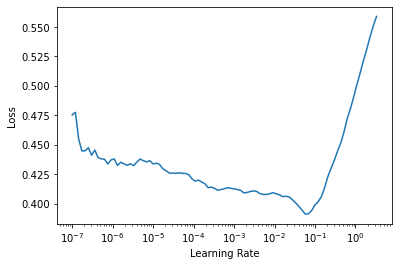

In [36]:
learn.lr_find()

It seems like 1e-2 is a good rate, as the plot is still decreasing, but is not too close to the large incline.

In [37]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049976,0.043061,02:25


epoch,train_loss,valid_loss,time
0,0.007528,0.002757,03:07
1,0.002950,0.000745,03:07
2,0.001428,0.000223,03:07


From the textbook: "Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:"

In [40]:
math.sqrt(0.0001)

0.01

Let's compare the actual coordinates to our model's predictions:

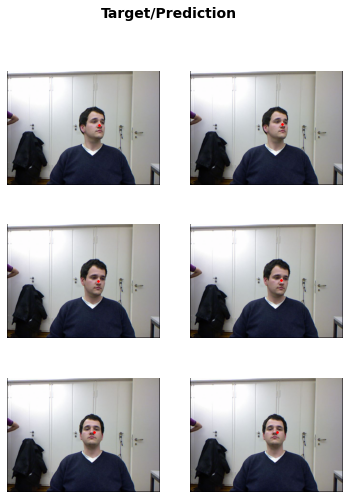

In [39]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

We use the same model across different applications (single-label classification, multi-label classification, regression), only changing the loss function.

Cheat sheet:

* Single-label classification: `nn.CrossEntropyLoss` (cross entropy
* Multi-label classification: `nn.BCEWithLogitsLoss` (binary cross entropy)
* Regression: `nn.MSELoss` (mean squared error)

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.